# Лабораторная работа №5 по курсу "Численные методы"
## Тема ЛР - "Начально-краевые задачи для дифференциального уравнения параболического типа"

Студент - Шавандрин Фёдор Михайлович

Группа - М8О-408Б-19

## Задание

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением *U(x, t)*.

### Вариант 3

$\large\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2}$  
$a > 0$  
$u(0,t) = e^{-at}$  
$u(\pi,t) = -e^{-at}$  
$u(x,0) = cos(x)$  
Аналитическое решение: $U(x,t) = e^{-at}cos(x)$

In [1]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt

Зададим начальные условия, а также коэффициенты *a*, *sigma* и *h* - размер сетки для координатной составляющей. Размер сетки для временной составляющей будем искать из формулы $\tau = \sigma {h^2 \over a}$.
### Константы

In [2]:
a = 1

x_start = 0
x_end = np.pi

t_start = 0
t_end = 5

h = 0.01
sigma = 0.37

### Начальные условия

In [3]:
def phi_0(t, a):
    return np.exp(-a * t)

def phi_1(t, a):
    return -np.exp(-a * t)

def psi(x):
    return np.cos(x)

def exact_sol(x, t, a):
    return np.exp(-a * t) * np.cos(x)

### Аналитическое решение
Найдем аналитическое решение начально-краевой задачи для дифференциального уравнения параболического типа, затем будем сравнивать его с численными методами для того. Это нам пригодится, чтобы визуализировать зависимость максимального модуля ошибки от времени. Для этого реализовал функцию, которая возвращает матрицу *U* со значениями функции для аналитического решения.

In [4]:
def analytical_solve(x_start, x_end, t_start, t_end, a, h, sigma):
    tau = sigma * h**2 / a
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)

    U = np.zeros((len(t), len(x)))
    for i_x in range(len(x)):
        for i_t in range(len(t)):
            U[i_t][i_x] = exact_sol(x[i_x], t[i_t], a)
    
    return U

In [5]:
anal_solution = analytical_solve(x_start, x_end, t_start, t_end, a, h, sigma)

In [6]:
anal_solution.shape

(135136, 315)

### Погрешность
В качестве погрешности буду использовать максимальный модуль ошибки.

In [7]:
def max_abs_error(U_num, U_anal):
    return abs(U_num - U_anal).max()

### Реализация функций построения графиков
Для того, чтобы визуализировать решение ДУ численными методами, реализую функцию построения графика функции *U(t)* при заданном времени *t*.

In [8]:
def build_numerical_results_graphic(solution, method_name, time, x_start, x_end, t_start, t_end, h, sigma):
    tau = sigma * h**2 / a
    x = np.arange(x_start, x_end, h)
    times = np.arange(t_start, t_end, tau)
    cur_t_id = abs(times - time).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_t_id], label='Аналитическое решение')
    plt.plot(x, solution[cur_t_id], label=method_name, color='r')
    
    plt.xlabel('x')
    plt.ylabel('U(t)')
    plt.legend()
    plt.grid()
    plt.show()

Чтобы проверить, наскольно точно решение ДУ численными методами, необходимо реализовать функцию построения графика зависимости погрешности (максимального модуля ошибки) от времени.

In [9]:
def build_errors_graphic(solution, method_name, t_start, t_end, h, sigma):
    tau = sigma * h**2 / a
    t = np.arange(t_start, t_end, tau)

    plt.figure(figsize=(15, 9))
    max_abs_errors = np.array([max_abs_error(solution[i], anal_solution[i]) for i in range(len(t))])
    plt.plot(t, max_abs_errors, label=method_name, color='g')

    plt.xlabel('Время')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

## Численные методы

### Явная конечно-разностная схема
Преобразуем исходное уравнение с производными в уравнение с их численными приближениями. Производную второго порядка в правой части уравнения будем аппроксимировать по значениям нижнего временного слоя.  
$\large\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2};$  
$\large{u^{k+1}_j - u^k_j} \over {\tau}$ = $\large a {{u^k_{j-1} - 2u^k_j+ u^k_{j+1}} \over {h^2}} =>$
$\large u^{k+1}_j$ = $\large\tau a {{u^k_{j-1} + (h^2 - 2)u^k_j+ u^k_{j+1}} \over {h^2}}$

Получили рекуррентное соотношение. Начальные условия позволяет нам посчитать значения *u* в нижнем временном ряду. Далее в цикле считаем значения в узлах сетки.  

Особенностью метода явной конечно-разностной схемы является условие $\sigma={{a\tau} \over {h^2}} < {1 \over 2}$, при котором данный метод сходится. В противном случае, погрешность вычисления будет очень большой.

In [10]:
def explicit_finite_difference_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi):
    assert sigma < (1/2)
    tau = sigma * h**2 / a
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)

    U = np.zeros((len(t), len(x)))
    # подсчитываем значения на нижней границе (t = 0)
    for i in range(len(x)):
        U[0][i] = psi(x[i])

    for dt in range(1, len(t)):
        # подсчитываем значения на левой границе (x = 0)
        U[dt][0] = phi_0(t[dt], a)
        for dx in range(1, len(x) - 1):
            U[dt][dx] = sigma * U[dt - 1][dx - 1] + (1 - 2 * sigma) * U[dt - 1][dx] + sigma * U[dt - 1][dx + 1]
        # подсчитываем значения на правой границе (x = pi)
        U[dt][-1] = phi_1(t[dt], a)
    return U

In [11]:
explicit_solution = explicit_finite_difference_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi)

In [12]:
explicit_solution.shape

(135136, 315)

### Максимальный модуль ошибки

In [35]:
print(f'Максимальный модуль ошибки = {max_abs_error(explicit_solution, anal_solution)}')

Максимальный модуль ошибки = 1.3637662959475882e-06


### Визуализация решения ДУ с помощью явной конечно-разностной схемы

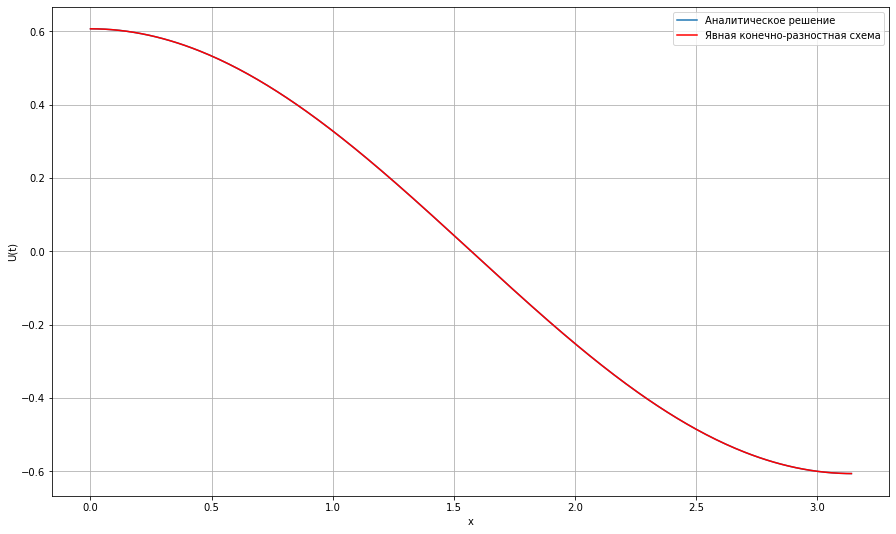

In [14]:
build_numerical_results_graphic(explicit_solution, "Явная конечно-разностная схема", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация погрешности метода явной конечно-разностной схемы

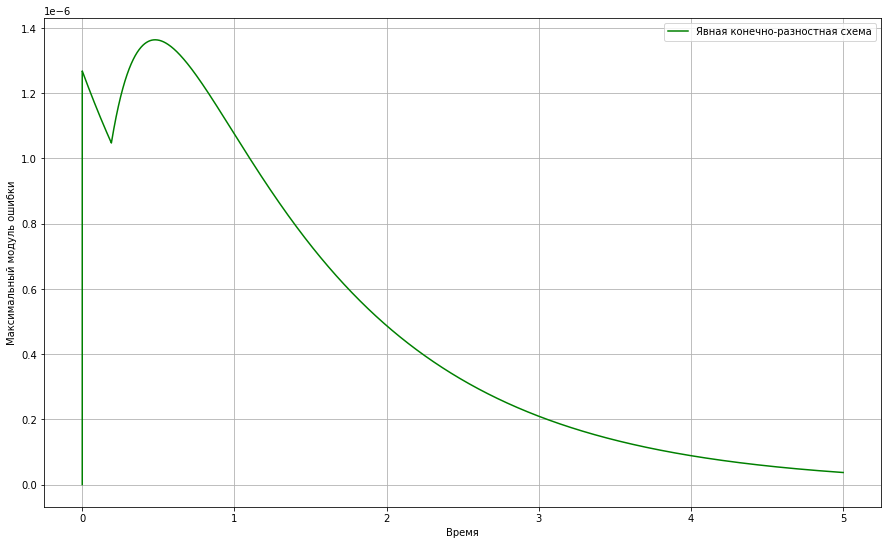

In [15]:
build_errors_graphic(explicit_solution, "Явная конечно-разностная схема", t_start, t_end, h, sigma)

### Неявная конечно-разностная схема

Преобразуем исходное уравнение с производными в уравнение с их численными приближениями. Производную второго порядка в правой части уравнения будем аппроксимировать по значениям нижнего временного слоя.  

Необходимо решить систему уравнений для того, чтобы получить значения *u* в одном временном ряду.  
Система уравнений имеет вид:  
\begin{cases} b_1u^{k+1}_1 + c_1u^{k+1}_2=d_1, \ j=1\\ a_ju^{k+1}_{j-1}+b_ju^{k+1}_{j} + c_ju^{k+1}_{j + 1} = d_j, \ j=2...(n-2) \\ a_{n-1}u^{k+1}_{n-2} + b_{n-1}u^{k+1}_{n-1}=d_{n-1}, \ j=n-1  \quad,где\end{cases}  
$a_j=c_j=\sigma= {{a\tau} \over {h^2}}$  
$b_j=-2\sigma - 1$  
$d_j=-u^k_j, \ j=2...(n-2)$  
$d_1=-\sigma\phi_0(t^{k+1}) - u^k_1$  
$d_{n-1}=-\sigma\phi_1(t^{k+1}) - u^k_{n-1}$  

Данная система уравнений представляет собой трёхдиагональную СЛАУ, которую можно решить, используя метод прогонки.

### Метод прогонки

In [16]:
def run_through_method(A, b):
    n = len(A)
    
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n - 1):
        v[i] = A[i][i + 1] / (-A[i][i] - A[i][i - 1] * v[i - 1])
        u[i] = (A[i][i - 1] * u[i - 1] - b[i]) / (-A[i][i] - A[i][i - 1] * v[i - 1])
    v[n - 1] = 0
    u[n - 1] = (A[n - 1][n - 2] * u[n - 2] - b[n - 1]) / (-A[n - 1][n - 1] - A[n - 1][n - 2] * v[n - 2])

    x = [0 for _ in range(n)]
    x[n - 1] = u[n - 1]
    for i in range(n - 1, 0, -1):
        x[i - 1] = v[i - 1] * x[i] + u[i - 1]
    return np.array(x)

In [17]:
def implicit_finite_difference_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi):
    assert sigma < (1/2)
    tau = sigma * h**2 / a 
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)
    U = np.zeros((len(t), len(x)))

    # подсчитываем значения на нижней границе (t = 0)
    for i in range(len(x)):
        U[0][i] = psi(x[i])

    for dt in range(1, len(t)):
        A = np.zeros((len(x) - 2, len(x) - 2))
        A[0][0] = -2 * sigma - 1
        A[0][1] = sigma
        for i in range(1, len(A) - 1):
            A[i][i - 1] = sigma
            A[i][i] = -2 * sigma - 1
            A[i][i + 1] = sigma
        A[-1][-2] = sigma
        A[-1][-1] = -2 * sigma - 1
        
        b = -U[dt - 1][1:-1]
        # подсчитываем значения, используя граничные условия
        b[0] -= sigma * phi_0(t[dt], a)
        b[-1] -= sigma * phi_1(t[dt], a)

        U[dt][0] = phi_0(t[dt], a)
        U[dt][-1] = phi_1(t[dt], a)
        # метод прогонки
        U[dt][1:-1] = run_through_method(A, b)
    return U

In [18]:
implicit_solution = implicit_finite_difference_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi)

In [19]:
implicit_solution.shape

(135136, 315)

### Максимальный модуль ошибки

In [34]:
print(f'Максимальный модуль ошибки = {max_abs_error(implicit_solution, anal_solution)}')

Максимальный модуль ошибки = 4.034005250619366e-06


### Визуализация решения ДУ с помощью неявной конечно-разностной схемы

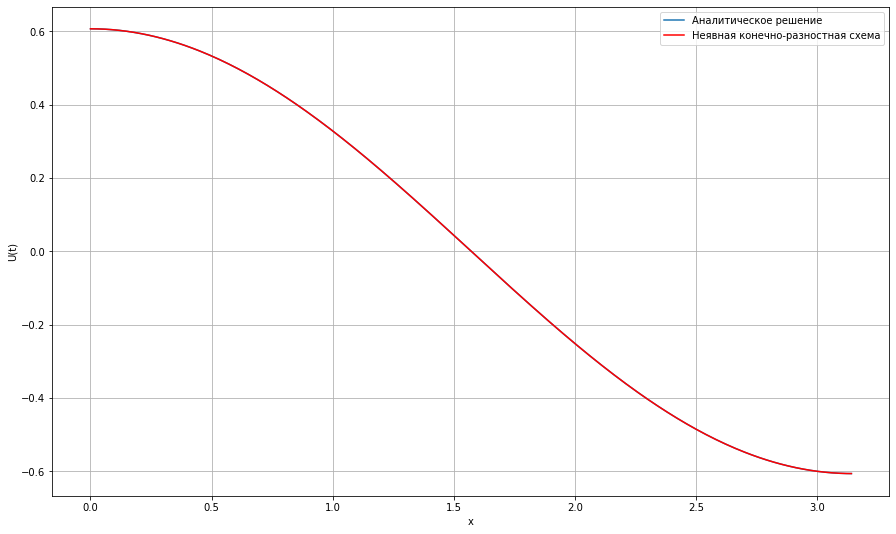

In [21]:
build_numerical_results_graphic(implicit_solution, "Неявная конечно-разностная схема", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация погрешности метода явной конечно-разностной схемы

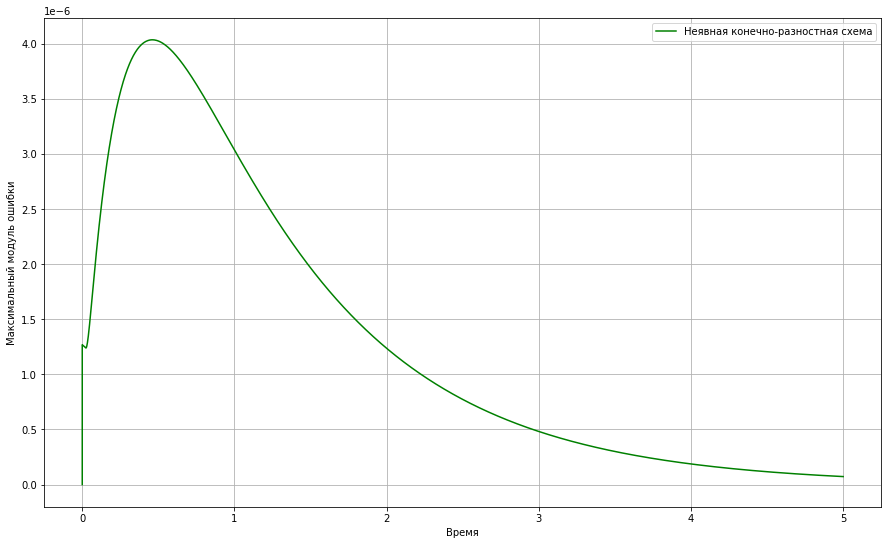

In [22]:
build_errors_graphic(implicit_solution, "Неявная конечно-разностная схема", t_start, t_end, h, sigma)

### Схема Кранка-Николсона
Скорректируем трехдиагональную СЛАУ из предыдущего метода с той разницей, что производную второго порядка будем аппроксимировать, используя выпуклую комбинацию (по значениям нижнего и верхнего временного слоя).  

Выпуклая комбинация - ЛК, при которой коэффициенты $\geq 0$ и в сумме дают единицу. Будем использовать коэффициенты $\theta$ и $1-\theta$. При $\theta = {1 \over 2}$ имеем схему Кранка-Николсона.

Скорректированя система уравнений будет иметь вид:  
\begin{cases} b_1u^{k+1}_1 + c_1u^{k+1}_2=d_1, \ j=1\\ a_ju^{k+1}_{j-1}+b_ju^{k+1}_{j} + c_ju^{k+1}_{j + 1} = d_j, \ j=2...(n-2) \\ a_{n-1}u^{k+1}_{n-2} + b_{n-1}u^{k+1}_{n-1}=d_{n-1}, \ j=n-1  \quad,где\end{cases}  
$a_j=c_j=\theta\sigma$  
$b_j=-2\theta\sigma - 1$  
$d_j=-(1-\theta)\sigma(u^k_{j-1}-2u^k_j+u^k_{j+1}) - u^k_j, \ j=2...(n-2)$  
$d_1=-\sigma\phi_0(t^{k+1}) - u^k_1$  
$d_{n-1}=-\sigma\phi_1(t^{k+1}) - u^k_{n-1}$  

Данная система уравнений представляет собой трёхдиагональную СЛАУ, которую можно решить, используя метод прогонки

In [23]:
def crank_nicolson_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi, theta=0.5):
    assert sigma < (1/2)
    tau = sigma * h**2 / a
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)
    U = np.zeros((len(t), len(x)))

    # подсчитываем значения на нижней границе (t = 0)
    for i in range(len(x)):
        U[0][i] = psi(x[i])

    for dt in range(1, len(t)):
        A = np.zeros((len(x) - 2, len(x) - 2))
        A[0][0] = -2 * sigma * theta - 1
        A[0][1] = sigma * theta
        for i in range(1, len(A) - 1):
            A[i][i - 1] = sigma * theta
            A[i][i] = -2 * sigma * theta - 1
            A[i][i + 1] = sigma * theta
        A[-1][-2] = sigma * theta
        A[-1][-1] = -2 * sigma * theta - 1
        
        b = np.array([-(U[dt - 1][i] + (1 - theta) * sigma * (U[dt - 1][i - 1] - 2 * U[dt - 1][i] + U[dt - 1][i + 1])
        ) for i in range(1, len(U[dt - 1]) - 1)])
        # подсчитываем значения, используя граничные условия
        b[0] -= sigma * theta * phi_0(t[dt], a)
        b[-1] -= sigma * theta * phi_1(t[dt], a)

        U[dt][0] = phi_0(t[dt], a)
        U[dt][-1] = phi_1(t[dt], a)
        # метод прогонки
        U[dt][1:-1] = run_through_method(A, b)

    return U

In [24]:
crank_nicolson_solution = crank_nicolson_method(x_start, x_end, t_start, t_end, a, h, sigma, phi_0, phi_1, psi)

In [25]:
crank_nicolson_solution.shape

(135136, 315)

### Максимальный модуль ошибки

In [33]:
print(f'Максимальный модуль ошибки = {max_abs_error(crank_nicolson_solution, anal_solution)}')

Максимальный модуль ошибки = 1.6059616916308528e-06


### Визуализация решения ДУ с помощью схемы Кранка-Николсона

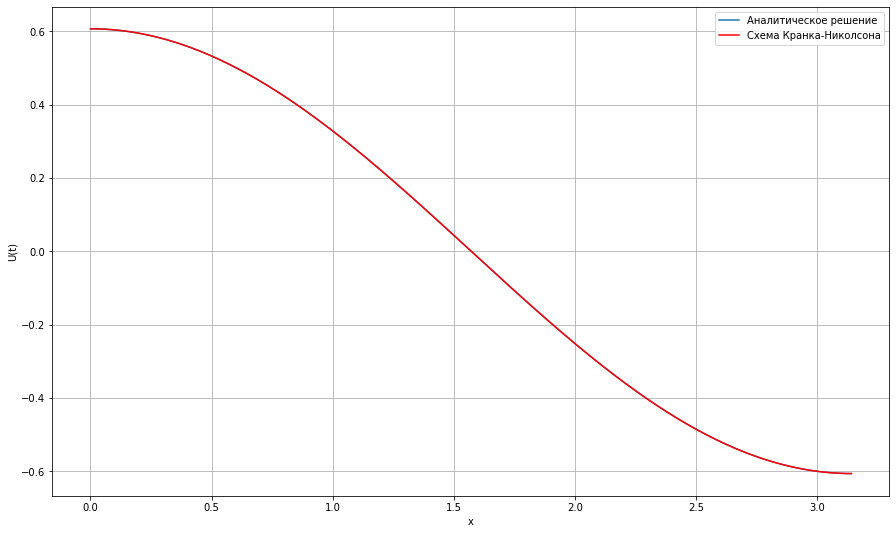

In [27]:
build_numerical_results_graphic(crank_nicolson_solution, "Схема Кранка-Николсона", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация погрешности метода схемы Кранка-Николсона

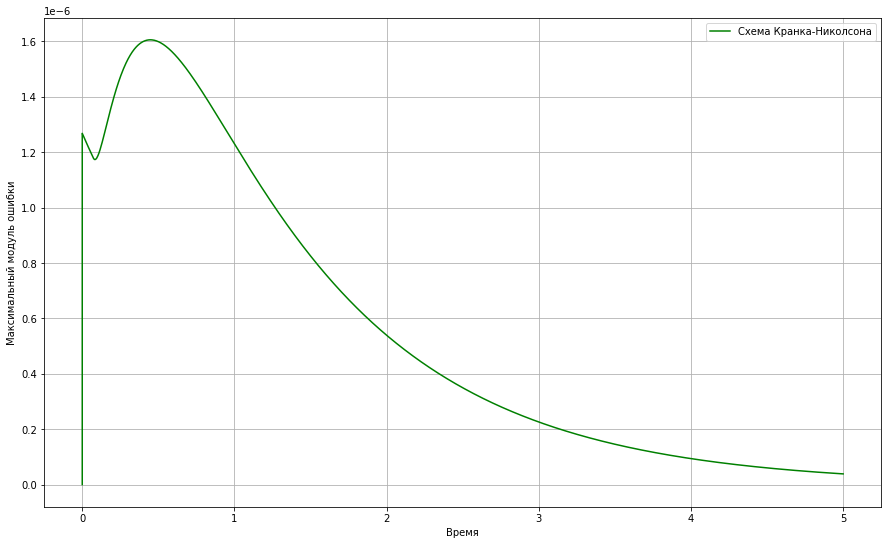

In [28]:
build_errors_graphic(crank_nicolson_solution, "Схема Кранка-Николсона", t_start, t_end, h, sigma)

### Сравнение численных методов с аналитическим решением

In [29]:
def build_all_numerical_results_graphic(sol1, sol2, sol3 , m_n1, m_n2, m_n3, time, x_start, x_end, t_start, t_end, h, sigma):
    tau = sigma * h**2 / a
    x = np.arange(x_start, x_end, h)
    times = np.arange(t_start, t_end, tau)
    cur_t_id = abs(times - time).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_t_id], label='Аналитическое решение')
    plt.plot(x, sol1[cur_t_id], label=m_n1, color='r')
    plt.plot(x, sol2[cur_t_id], label=m_n2, color='g')
    plt.plot(x, sol3[cur_t_id], label=m_n3, color='m')
    
    plt.xlabel('x')
    plt.ylabel('U(t)')
    plt.legend()
    plt.grid()
    plt.show()

In [30]:
def build_all_errors_graphic(sol1, sol2, sol3, m_n1, m_n2, m_n3, t_start, t_end, h, sigma):
    tau = sigma * h**2 / a
    t = np.arange(t_start, t_end, tau)

    plt.figure(figsize=(15, 9))
    max_abs_errors1 = np.array([max_abs_error(sol1[i], anal_solution[i]) for i in range(len(t))])
    max_abs_errors2 = np.array([max_abs_error(sol2[i], anal_solution[i]) for i in range(len(t))])
    max_abs_errors3 = np.array([max_abs_error(sol3[i], anal_solution[i]) for i in range(len(t))])
    plt.plot(t, max_abs_errors1, label=m_n1, color='g')
    plt.plot(t, max_abs_errors2, label=m_n2, color='r')
    plt.plot(t, max_abs_errors3, label=m_n3, color='m')

    plt.xlabel('Время')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

### Визуализация результатов работы численных методов

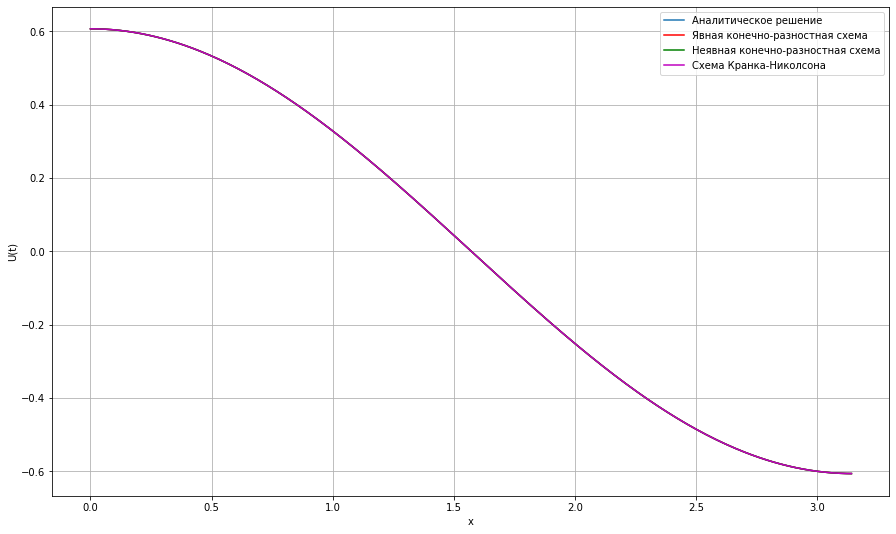

In [31]:
build_all_numerical_results_graphic(explicit_solution, implicit_solution, crank_nicolson_solution , "Явная конечно-разностная схема", "Неявная конечно-разностная схема", "Схема Кранка-Николсона", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация зависимости погрешности от времени для численных методов

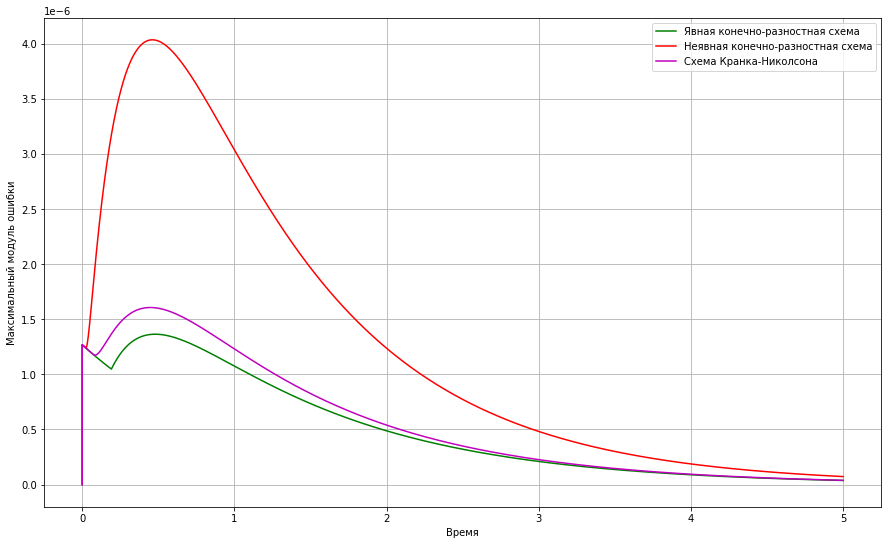

In [32]:
build_all_errors_graphic(explicit_solution, implicit_solution, crank_nicolson_solution , "Явная конечно-разностная схема", "Неявная конечно-разностная схема", "Схема Кранка-Николсона", t_start, t_end, h, sigma)

### Выводы
В данной лабораторной работе изучил три метода для решения начально-краевой задачи для дифференциального уравнения параболического типа:
- явная конечно-разностная схема;
- неявная конечно-разностная схема;
- схема Кранка-Николсона.  

Полученное решение заданного ДУ данными методами имеет довольно большую точность. Построил графики зависимости погрешности от времени для всех численных методов.  

В процессе выполнения данной лабораторной работы изучил преимущества и недостатки численных методов.  

Для явной конечно-разностной схемы обязательным требованием является условие сходимости метода $\sigma < {1 \over 2}$, тем не менее, данный метод является простым в реализации.  
Неявная конечно-разностная схема обуславливается сложностью вычислений, так как необходимо решать большое количество СЛАУ. Однако для данного метода, как и для схемы Кранка-Николсона ограничение $\sigma < {1 \over 2}$ не требуется.  
Схема Кранка-Николсона "сочетает" в себе два предыдущих метода и вследствие этого имеет наименьшую погрешность, хотя всё также использует сложные вычисления, как неявная конечно-разностная схема.